In [1]:
import sys
sys.path.append('..')

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pickle
import seaborn as sns
import pandas as pd
import numpy as np

from scipy.stats import entropy
from matplotlib import pyplot as plt

from trickster.wfp_helper import load_data, extract

In [3]:
sns.set_context('notebook')

plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')

## Load the small WFP models

Each 'small model' trained on a small subset of 100 random traces

In [4]:
model_pickle_names = ['../models/small_model_{}.pkl'.format(i) for i in range(1, 20)]
models = [pickle.load(open(filename, 'rb')) for filename in model_pickle_names]

In [5]:
coefs = [model.coef_[0] for model in models]

We want to compare their coefficient vectors. Some of them have the coefficients rather monotone and smooth, others are changing more abruptly.

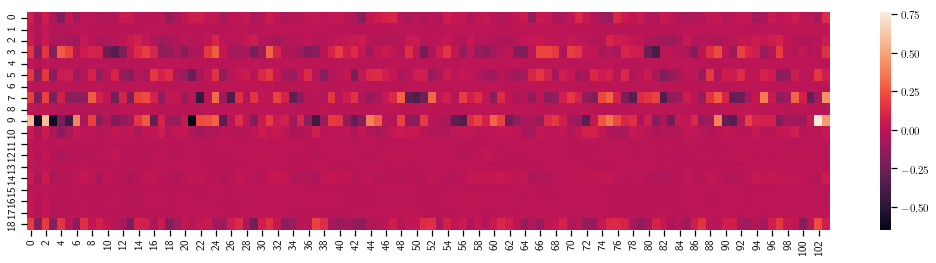

In [6]:
fig, ax = plt.subplots()
fig.set_figwidth(18)

sns.heatmap(coefs, ax=ax)

## Load the reports on generative adversarial examples against the models

In [7]:
adv_results_pickle_names = ['../out/results_small_model_{}.pkl'.format(i)
                            for i in range(1, 20)]
adv_results = [pd.read_pickle(filename) for filename in adv_results_pickle_names]

Compute the adverage success rate for the model (the iteration limit was 100 expansions)

In [8]:
success_rates = []
for results_df in adv_results:
    rate = results_df.found.mean()
    success_rates.append(rate)

And the average number of graph node expansions for each model

In [16]:
exp_counts = []
for results_df in adv_results:
    count = results_df[results_df.found].nodes_expanded.mean()
    exp_counts.append(count)

We measure the abruptness of change of coefficients using statistical entropy.

In [10]:
ents = [entropy(coef - np.min(coef)) for coef in coefs]

## Visualizing model robustness vs. coefficient entropy

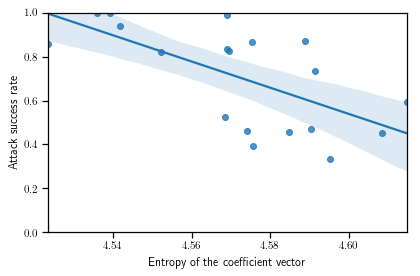

In [18]:
fig, ax = plt.subplots()

fig.set_tight_layout(tight=True)

ax.set_xlabel('Entropy of the coefficient vector')
ax.set_ylabel('Attack success rate')
ax.set_ylim(0, 1)
ax.set_xlim(min(ents), max(ents))

sns.regplot(ents, success_rates, ax=ax)

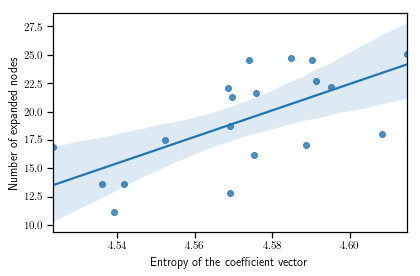

In [19]:
fig, ax = plt.subplots()

fig.set_tight_layout(tight=True)

ax.set_xlabel('Entropy of the coefficient vector')
ax.set_ylabel('Number of expanded nodes')
ax.set_xlim(min(ents), max(ents))

sns.regplot(ents, exp_counts, ax=ax)